In [235]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sys

In [202]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

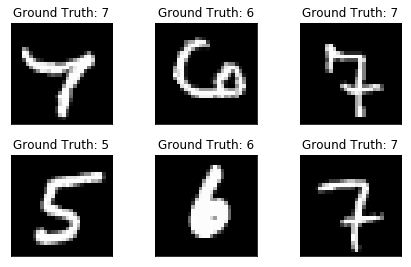

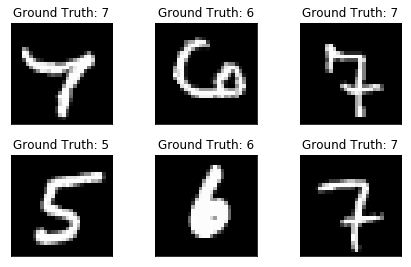

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [23]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [24]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [25]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [26]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3183, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343074
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.308185
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.316915
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.282528
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.262036
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.284773
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225686
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.239281
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.186706
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.162821
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.156885
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.003726
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.968022
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.848698
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.834869
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.956961
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.621204
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.580370
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.340080
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.370618
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.191759
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.283365
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.317247
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.311691
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.394043
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.354211
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.347386
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.291527
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.451456
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.244689
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.384453
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.249814
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.282917
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.448238
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.500237
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.255896
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.242994
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.126581
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.326104


Text(0,0.5,'negative log likelihood loss')

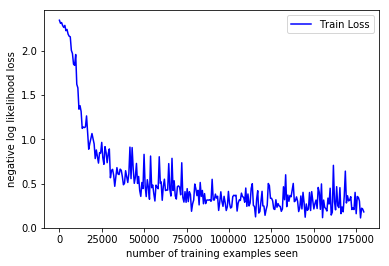

In [27]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [27]:
with torch.no_grad():
  output = network(example_data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


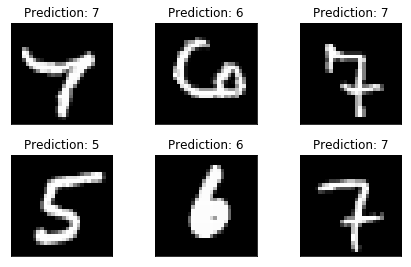

In [47]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
#fig

In [29]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [32]:
network_state_dict = torch.load("results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [33]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.234887
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.273640
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.278434
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.220207
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.447623
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.199281
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.205771
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.168196
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.258815
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.300615
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.292549
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.267514
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.137081
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.272698
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.080452
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.157477
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.414477
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.367064
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.361885
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.238028
Train Epoch: 4 [12800/60000 (

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0821, Accuracy: 9749/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.355695
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.117887
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.236749
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.183078
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.201221
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.455118
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.191014
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.115509
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.236347
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.086094
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.274722
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.253364
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.188894
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.130159
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.219244
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.207292
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.133349
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.190143
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.200767
Train Epoch: 5 [12160

Train Epoch: 6 [44160/60000 (74%)]	Loss: 0.113984
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.320447
Train Epoch: 6 [45440/60000 (76%)]	Loss: 0.131572
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.222457
Train Epoch: 6 [46720/60000 (78%)]	Loss: 0.437250
Train Epoch: 6 [47360/60000 (79%)]	Loss: 0.199463
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.120966
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.232054
Train Epoch: 6 [49280/60000 (82%)]	Loss: 0.523821
Train Epoch: 6 [49920/60000 (83%)]	Loss: 0.158857
Train Epoch: 6 [50560/60000 (84%)]	Loss: 0.159470
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.229407
Train Epoch: 6 [51840/60000 (86%)]	Loss: 0.268722
Train Epoch: 6 [52480/60000 (87%)]	Loss: 0.183258
Train Epoch: 6 [53120/60000 (88%)]	Loss: 0.077825
Train Epoch: 6 [53760/60000 (90%)]	Loss: 0.135525
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.299407
Train Epoch: 6 [55040/60000 (92%)]	Loss: 0.185160
Train Epoch: 6 [55680/60000 (93%)]	Loss: 0.363146
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.143961


Train Epoch: 8 [28160/60000 (47%)]	Loss: 0.229944
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.109479
Train Epoch: 8 [29440/60000 (49%)]	Loss: 0.165987
Train Epoch: 8 [30080/60000 (50%)]	Loss: 0.116785
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.113736
Train Epoch: 8 [31360/60000 (52%)]	Loss: 0.174259
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.079879
Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.061913
Train Epoch: 8 [33280/60000 (55%)]	Loss: 0.109410
Train Epoch: 8 [33920/60000 (57%)]	Loss: 0.182871
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.172913
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.169186
Train Epoch: 8 [35840/60000 (60%)]	Loss: 0.382055
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.137640
Train Epoch: 8 [37120/60000 (62%)]	Loss: 0.123572
Train Epoch: 8 [37760/60000 (63%)]	Loss: 0.196703
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.241467
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.109546
Train Epoch: 8 [39680/60000 (66%)]	Loss: 0.121446
Train Epoch: 8 [40320/60000 (67%)]	Loss: 0.113228


Text(0,0.5,'negative log likelihood loss')

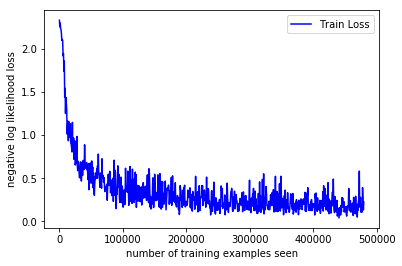

In [61]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [28]:
with torch.no_grad():
    step_1 = network.conv1(example_data)
    step_2 = F.max_pool2d(step_1,2)
    step_3 = F.relu(step_2)
    step_4 = network.conv2(step_3)
    step_5 = F.max_pool2d(step_4,2)
    step_6 = F.relu(step_5)

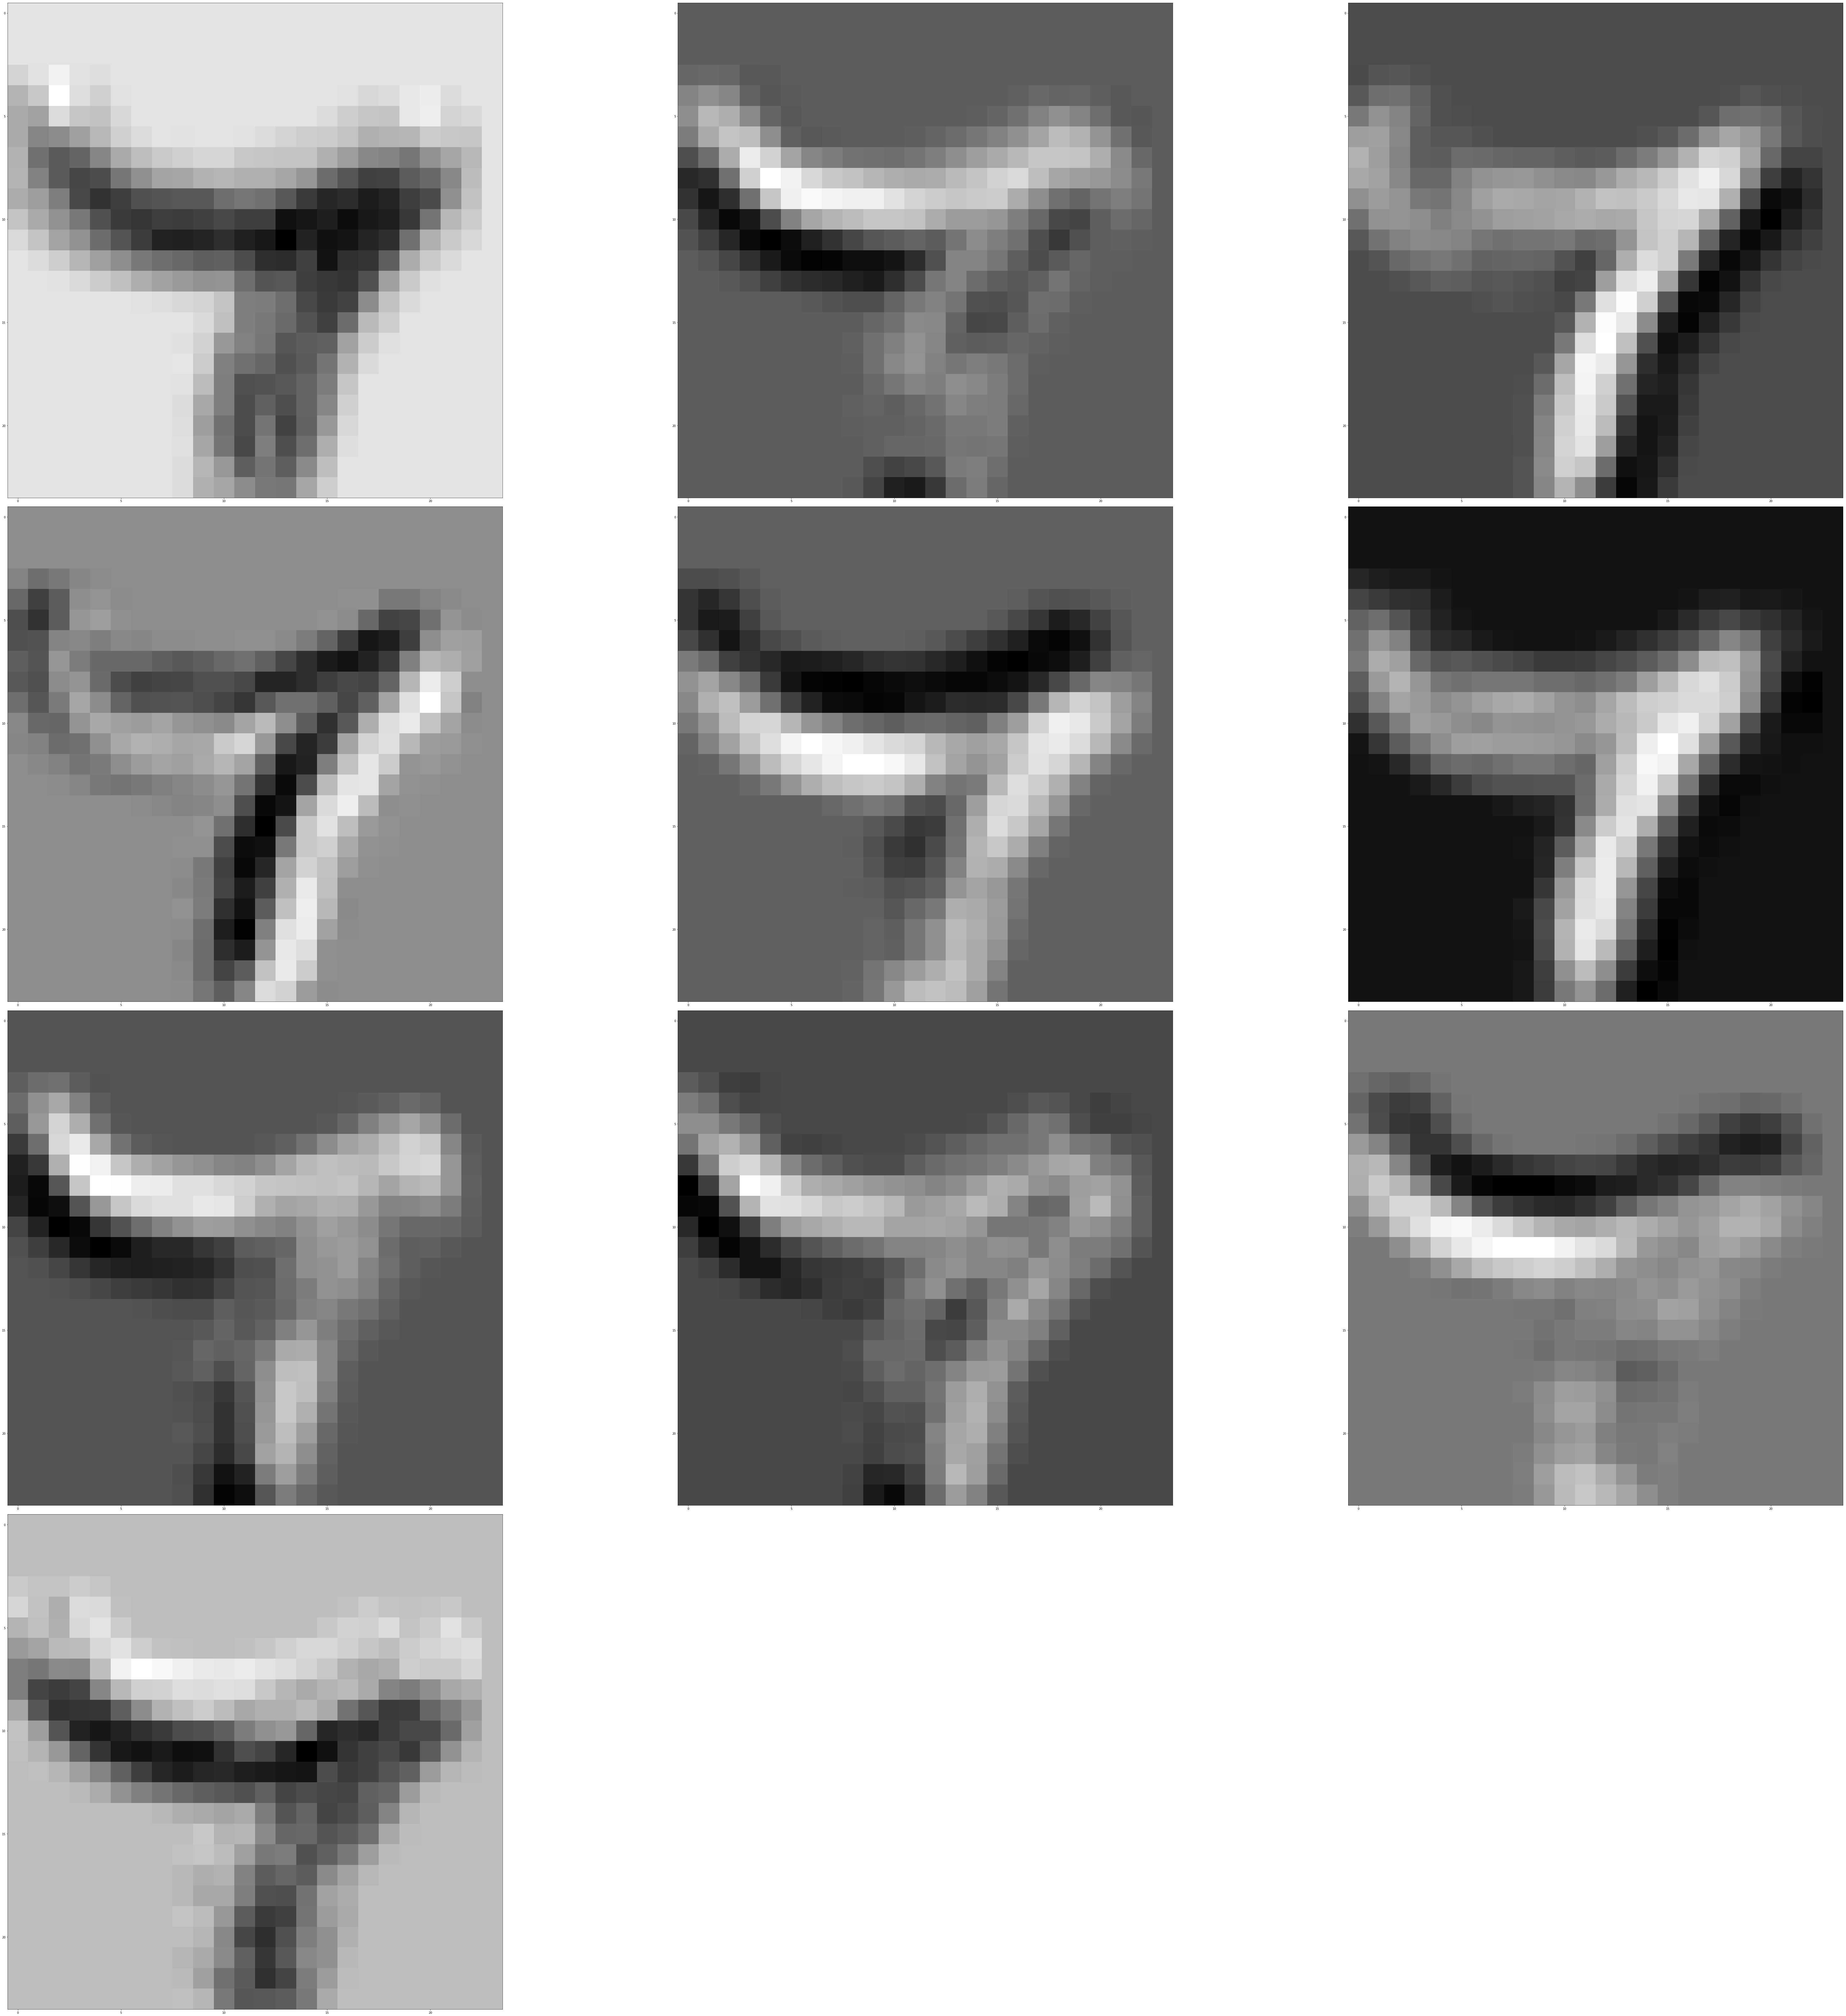

In [29]:
fig = plt.figure(figsize=(100,100))
for i,data in enumerate(step_1[0]):
    plt.subplot(4,3,i+1)
    plt.tight_layout()
    plt.imshow(data, cmap='gray', interpolation='none')

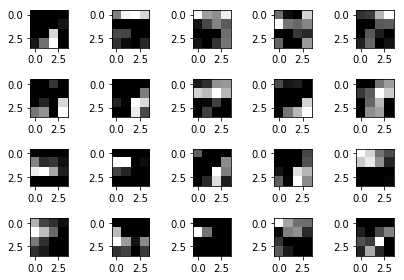

In [112]:
fig = plt.figure()
for i,data in enumerate(flt_conv2[0]):
    plt.subplot(4,5,i+1)
    plt.tight_layout()
    plt.imshow(data, cmap='gray', interpolation='none')

In [113]:
flt_conv1[0].size()

torch.Size([10, 12, 12])

In [114]:
flt_conv2[0].size()

torch.Size([20, 4, 4])

In [103]:
example_data.size()

torch.Size([1000, 1, 28, 28])

In [238]:
#returns an expression to get the transformed coordinates 
# from the original dimensions to the 1 dimension flattened data
def getExpr(size):
    val = ""
    lst = []
    if len(size) > 1:
        for i in range(1,len(size)):
            temp = "xi[{}]".format(i-1)
            for j in range(i,len(size)):
                temp += "*{}".format(size[j])
            lst.append(temp)
    else:
        i = 0
    val += "+".join(lst)
    val += "+xi[{}]".format(i)
    return val

#returns an array with the position in the flattened data
#coords is an array with coordinate relative to the cell in the original dimensions
# size = np.shape(data)
def getNeighbors(cell,coords,size):
    newCoords = []
    expr = getExpr(size)
    for coord in coords:
        xi = []
        outOfBounds = False
        for i,c in enumerate(cell):
            if type(coord) != int:
                v = c+coord[i]
                if v >= size[i] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(v)
            else:
                v = c+coord
                if v >= size[0] or v < 0:
                    outOfBounds = True
                else:
                    xi.append(c+coord)
        if outOfBounds:
            newCoords.append(-1)
        else:
            newCoord = eval(expr)
            newCoords.append(newCoord)
            
    return newCoords

#returns the values of the neighbors of a certain cell
#data = flattened array of the data
#neighbors = the positions of neighbors of a certain cell
#paddingtype = 0 => don't get values,1=> fill with padding value, 2 => don't fill and return empty dict
#paddingvalue = the values to fill when the padding type equals 1
def getNeighborsValue(data,neighbors,paddingType = 0,paddingValue=0):
    values = {}
    for n in neighbors:
        val = None
        if n >= 0 and n < len(data):
                val = data[n]
        else:
            if paddingType == 0: continue
            elif paddingType == 1:
                val = paddingValue
            elif paddingType == 2:
                values = None
                break
        if val != None:
            values[n] = val
    return values

''' 
Example
data = np.array([[1,2,3],[4,5,6],[7,8,9]])
neighbors = getNeighbors([1,0],[[-1,-1],[0,-1],[1,-1]],np.shape(data))
print(data.reshape(-1))
print(neighbors)
print(getNeighborsValue(data.reshape(-1),neighbors,1,1))

ouput:
[1 2 3 4 5 6 7 8 9]
[-1, 2, 5]
{-1: 1, 2: 3, 5: 6}
'''

' \nExample\ndata = np.array([[1,2,3],[4,5,6],[7,8,9]])\nneighbors = getNeighbors([1,0],[[-1,-1],[0,-1],[1,-1]],np.shape(data))\nprint(data.reshape(-1))\nprint(neighbors)\nprint(getNeighborsValue(data.reshape(-1),neighbors,1,1))\n\nouput:\n[1 2 3 4 5 6 7 8 9]\n[-1, 2, 5]\n{-1: 1, 2: 3, 5: 6}\n'

In [193]:
data = example_data.numpy()
convData = {}
for ie,example in enumerate(data):
    print(ie)
    dim = np.shape(example)[1:3] #do this because dim = [1,28,28] should be [28,28]
    planned = example.reshape(-1) 
    kernel = [[-2,-2],[-1,-2],[0,-2],[1,-2],[2,-2],
              [-2,-1],[-1,-1],[0,-1],[1,-1],[2,-1],
              [-2,0],[-1,0],[0,0],[1,0],[2,0],
              [-2,1],[-1,1],[0,1],[1,1],[2,1],
              [-2,2],[-1,2],[0,2],[1,2],[2,2]]
    for i in range(dim[0]):
        for j in range(dim[1]):
            neighbors = getNeighbors([i,j],kernel,dim)
            if neighbors != None:
                values = getNeighborsValue(planned,neighbors,2)
                temp = []
                x,y = (i-2,j-2)
                for key in values:
                    temp.append(values[key])
                for k,row in enumerate(step_1[ie]):
                    if k not in convData:
                        convData[k] = []
                    convData[k].append(np.concatenate((temp,[row[x][y]])))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [194]:
#clean repeated values:
convData2 = {}
for key in convData:
    flt = {}
    convData2[key] = []
    for i,row in enumerate(convData[key]):
        x = ",".join(map(str,row))
        if x not in flt:
            flt[x] = True
            convData2[key].append(row)
    print(len(convData[key]))

576000
576000
576000
576000
576000
576000
576000
576000
576000
576000


In [196]:
dirName = "step_1/"
if not os.path.exists(dirName):
        os.mkdir(dirName)
for key in convData2:
    np.savetxt(dirName+str(key)+".csv", np.array(convData2[key]), delimiter=",")

In [203]:
dataset = pd.read_csv("step_1/0.csv")

In [233]:
for i in range(len(dataset.columns)):
    print(i,len(dataset[dataset.columns[i]].unique()))

0 256
1 256
2 256
3 256
4 256
5 256
6 256
7 256
8 256
9 256
10 256
11 256
12 256
13 256
14 256
15 256
16 256
17 256
18 256
19 256
20 256
21 256
22 256
23 256
24 256
25 308581


In [246]:
len(dataset.columns)

26

In [245]:
data = np.array([[1,2,3],[4,5,6],[7,8,9]])
neighbors = getNeighbors([1,0],[[-1,-1],[0,-1],[1,-1]],np.shape(data))
print(data.reshape(-1))
print(neighbors)
print(getNeighborsValue(data.reshape(-1),neighbors,2))

[1 2 3 4 5 6 7 8 9]
[-1, -1, -1]
None
